### Power Spectrum of example cell

In [1]:
#%%
from Cell_Class.Stim_Calculators import Stim_Cells
from Cell_Class.Format_Cell import Cell
import OS_Tools_Kit as ot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import cv2
from Kill_Cache import kill_all_cache
from sklearn.model_selection import cross_val_score
from sklearn import svm
from scipy.stats import pearsonr
import scipy.stats as stats
from Cell_Class.Plot_Tools import Plot_3D_With_Labels
import copy
from Cell_Class.Advanced_Tools import *
from Classifier_Analyzer import *
from Cell_Class.Timecourse_Analyzer import *


wp = r'D:\_All_Spon_Data_V1\L76_18M_220902'
ac = ot.Load_Variable_v2(wp,'Cell_Class.pkl')
spon_series = ot.Load_Variable(wp,'Spon_Before.pkl').reset_index(drop = True)
orien_series = ac.Z_Frames['1-007']



___
#### Define  Frequency transfer function
Transfer each cell's response time course into a frequency information.

In [2]:
def Transfer_Into_Freq(input_matrix,freq_bin = 0.01,fps = 1.301):
    input_matrix = np.array(input_matrix)
    # get raw frame spectrums.
    all_specs = np.zeros(shape = ((input_matrix.shape[0]// 2)-1,input_matrix.shape[1]),dtype = 'f8')
    for i in range(input_matrix.shape[1]):
        c_series = input_matrix[:,i]
        c_fft = np.fft.fft(c_series)
        power_spectrum = np.abs(c_fft)[1:input_matrix.shape[0]// 2] ** 2
        power_spectrum = power_spectrum/power_spectrum.sum()
        all_specs[:,i] = power_spectrum
    
    binnum = int(fps/(2*freq_bin))
    binsize = round(len(all_specs)/binnum)
    binned_freq = np.zeros(shape = (binnum,input_matrix.shape[1]),dtype='f8')
    for i in range(binnum):
        c_bin_freqs = all_specs[i*binsize:(i+1)*binsize,:].sum(0)
        binned_freq[i,:] = c_bin_freqs
    return binned_freq

spon_freqs = Transfer_Into_Freq(spon_series)
orien_freqs = Transfer_Into_Freq(orien_series)

Plot frequency power distribution of all cells. (Fig 1L)

[Text(0, 0, '0'), Text(10, 0, '0.1'), Text(20, 0, '0.2'), Text(30, 0, '0.3')]

<Figure size 640x480 with 0 Axes>

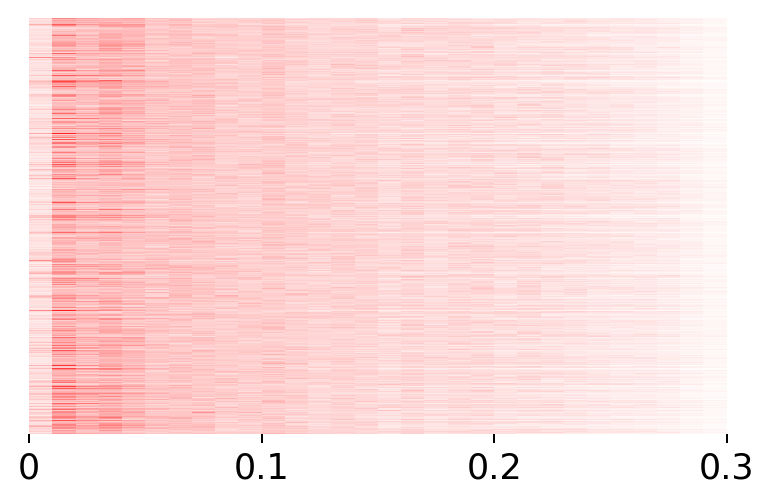

In [7]:

plt.clf()
fontsize = 14

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,3),dpi = 180,sharex= True)
sns.heatmap(spon_freqs[:30,:].T,center = 0,vmax=0.2,ax = ax,cbar=False,xticklabels=False,yticklabels=False,cmap = 'bwr')
ax.set_xticks([0,10,20,30])
ax.set_xticklabels([0,0.1,0.2,0.3],fontsize = fontsize)

Average powe of all cells, and plot global power distribution (Fig 1M)

Text(0.5, 0, '')

<Figure size 640x480 with 0 Axes>

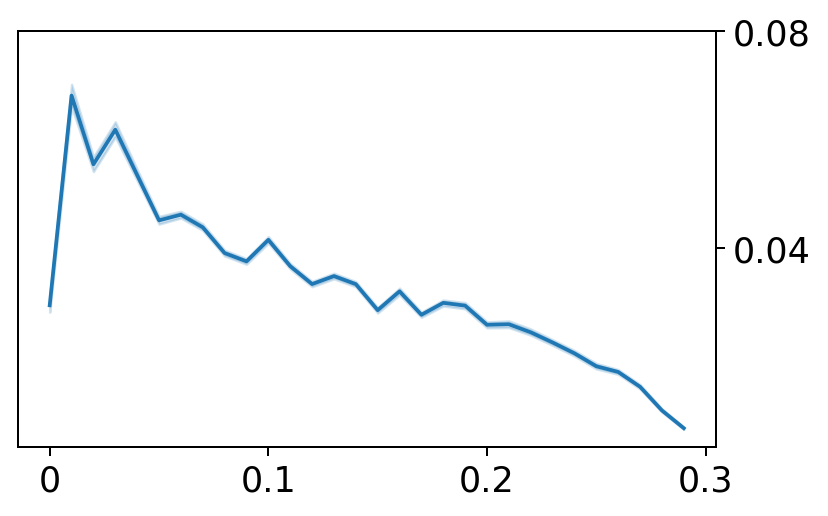

In [9]:
#melt response of each cell into a pd frame, then use seaborn plot it with errobar.
plotable_power = pd.DataFrame(spon_freqs[:30,:].T).melt(var_name='Freq',value_name='Prop.')

plt.clf()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,3),dpi = 180,sharex= True)
sns.lineplot(data = plotable_power,x='Freq',y='Prop.',ax = ax)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_xticks([0,10,20,30])
ax.set_xticklabels([0,0.1,0.2,0.3],fontsize = fontsize)
ax.set_yticks([0.04,0.08])
ax.set_yticklabels([0.04,0.08],fontsize = fontsize)
ax.set_ylabel('')
ax.set_xlabel('')